In [1]:
import numpy as np
import matplotlib.pyplot as plt
import popsims 
import wisps
import pandas as pd
import wisps.simulations as wispsim
from tqdm import tqdm 
import astropy.units as u
import numba
%matplotlib inline

Adding 145 sources from /Users/caganze/research/splat//resources/Spectra/Public/LRIS-RED/ to spectral database
Adding 89 sources from /Users/caganze/research/splat//resources/Spectra/Public/MAGE/ to spectral database
Adding 2404 sources from /Users/caganze/research/splat//resources/Spectra/Public/SPEX-PRISM/ to spectral database


In [2]:
#basic parameters with the usual assumptions 
model='baraffe2003'
models=[model]
p_data={}
for m in models:
    p_data.update({m:\
    popsims.make_systems(model_name=m, recompute=False, range=[0.01, 0.1, 8, 14.0],\
    nsample=5e4, filename='/users/caganze/research/popsims/data/{}_thick.pkl'.format(m))})
    
    p_data.update({m+'thin': popsims.make_systems(model_name=m, 
                                                  recompute=False,  range=[0.01, 0.1, 0, 8.0],
                  nsample=5e4, filename='/users/caganze/research/popsims/data/{}.pkl'.format(m))})

In [3]:
#

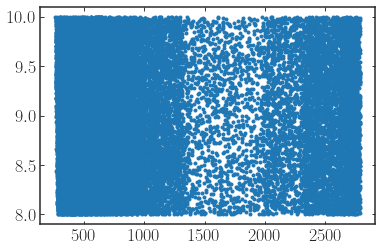

In [4]:
plt.plot(p_data[model]['system_teff'], p_data[model]['system_age'], '.')


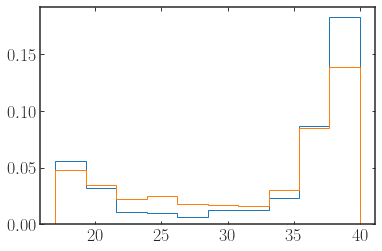

In [5]:
h=plt.hist(p_data[model]['system_spts'], range=[17, 40], bins=10, density=True, histtype='step')
h=plt.hist(p_data[model+'thin']['system_spts'], range=[17, 40], bins=10, density=True, histtype='step')

In [6]:
 DISTANCE_SAMPLES=pd.read_pickle(wisps.OUTPUT_FILES+'/distance_samples{}.gz'.format(900))

In [7]:
thin_pnts=pd.read_pickle(wisps.OUTPUT_FILES+'/pointings_correctedf110.pkl')

In [8]:

#create new_pointings withe same parameters but different scaleheights 

In [9]:
#wispsim.MAG_LIMITS

In [10]:
#get_numbers?
@numba.jit(nopython=True)
def fit_snr_exptime(ts, mag, d, e, f):
    return d*mag+e*np.log(ts/1000)+f

def get_snr(exp_grism, appf110s, appf140s, appf160s):
    #print (exp_grism)
    snrjs110= 10**(fit_snr_exptime(  exp_grism, appf110s, *list(wispsim.MAG_LIMITS['snr_exp']['F110'])))
    snrjs140= 10**(fit_snr_exptime(  exp_grism, appf140s, *list(wispsim.MAG_LIMITS['snr_exp']['F140'])))
    snrjs160= 10**(fit_snr_exptime(  exp_grism, appf160s, *list(wispsim.MAG_LIMITS['snr_exp']['F160'])))
    return np.nanmin(np.vstack([snrjs110, snrjs140, snrjs160]), axis=0)
    
def format_maglimits(wisp_limits):
    return {'WFC3_F110W':[16, wisp_limits['F110']],\
           'WFC3_F140W':[16, wisp_limits['F140']],\
           'WFC3_F160W':[16,wisp_limits['F160']]}

def make_cuts(df, dcts, expt):
    snr=get_snr(expt, df.WFC3_F110W.values, df.WFC3_F140W.values, df.WFC3_F160W.values)
    bools0=np.logical_or.reduce([df[k]< dcts[k][1] for k in dcts.keys()])
    return df[np.logical_and(bools0, snr>=3)]

def get_average_distance_limits(p, cuts):
    p.mag_limits=cuts
    return dict(pd.DataFrame(p.distance_limits).applymap(lambda x: \
                    x[1]).apply(lambda x: np.nanmedian(x), axis=1))

In [11]:
fov=4.1*(u.arcmin**2)
lf=pd.read_pickle('/Users/caganze/research/wisps/db/lf_scales.pkl')
        #scale lf

In [12]:
#thin_pnt_index=np.arange(0, len(thin_pnts))

In [13]:
def get_numbers(w_pnts, fov, model_name='baraffe2003'):
    pointings=[popsims.Pointing(coord=p.coord, name=p.name) for p in tqdm(w_pnts)]
    mlimits=[x.mag_limits for x in w_pnts]
    exptimes=[x.exposure_time for x in w_pnts]
    NCOUNTS={}
    COUNT_DF={}
    for pintdex, pz in tqdm(enumerate(w_pnts)):
        
        scale=lf['baraffe2003']
        teffs=p_data[model_name]['system_teff']
        spts= p_data[model_name]['system_spts']
        mask= np.logical_and( spts>=17, spts<=41)
        sn=len(teffs[np.logical_and(teffs>=450, teffs<=1950)])
        
        p= popsims.Pointing(coord=pz.coord, name=pz.name) 
        ml=pz.mag_limits
        cuts=format_maglimits(ml)
        spt_r=np.floor(spts).astype(int)[mask]
        dct= get_average_distance_limits(p, cuts)
    
        assert (len(spts[mask])== len(p_data[model_name]['system_age'][mask]))

            
        ds= np.array([np.random.choice(DISTANCE_SAMPLES[k][pintdex]) for k in spt_r])
        #print (ds)
        dff= popsims.create_population(p_data[model_name],p.coord, h=900, ds=ds, kind='disk', mask=mask)
    
        df_cut= make_cuts(dff, cuts, pz.exposure_time)
        
        nxbr_counts=[]
        
        for spt in np.arange(17, 40):
            sptvol=popsims.volume_calc(p.coord.galactic.l.radian, p.coord.galactic.b.radian,
                                       1., dct[spt], 900)*(fov.to(u.radian**2)).value
            df_select= df_cut[np.logical_and(df_cut.spt>=spt, df_cut.spt<spt+0.99)]
            

            nbrs=len(df_select)
            cnbrs=nbrs*sptvol*(scale[-1]/sn)
            nxbr_counts.append(cnbrs)
        NCOUNTS[p.name]=np.array(nxbr_counts)
        COUNT_DF[p.name]=df_cut
        #NCOUNTS[p.name+'df']=df_cut
    return NCOUNTS, COUNT_DF

In [14]:
#dff= popsims.create_population(p_data[m],thin_pnts[0].coord, h=900, kind='disk')

In [15]:
#snrs=get_snr(thin_pnts[0].exposure_time,\
#        dff.WFC3_F110W.values,dff.WFC3_F140W.values,dff.WFC3_F160W.values)

In [16]:
#

In [17]:
#thin_pnts[:2]

In [18]:
#df_cut

In [25]:
NUMBERS, OUT_DF=get_numbers(thin_pnts, fov, model_name='baraffe2003')

100%|██████████| 533/533 [38:31<00:00,  4.34s/it]
533it [1:02:56,  7.09s/it]


In [20]:
#OUT_DF

In [21]:
def bin_by_spt_bin(sp_types, number, ltonly=False):
    ranges=[[17, 20], [20, 25], [25, 30], [30, 35], [35, 40]]
    if ltonly:
        ranges=[[17, 20], [20, 30], [30, 41]]
    numbers=[]
    for r in ranges:
        idx= np.logical_and((r[0]<=sp_types), (r[1]>sp_types))
        numbers.append(np.nansum(number[idx]))
    return numbers



In [22]:
def compute_volume(px, spt):
    cuts=format_maglimits(px.mag_limits)
    p=popsims.Pointing(coord=px.coord, name=px.name) 
    dct=get_average_distance_limits(p, cuts)
    return popsims.volume_calc(p.coord.galactic.l.radian, p.coord.galactic.b.radian,
                                       1., dct[spt], 900)*(fov.to(u.radian**2)).value

In [26]:
ns=(pd.DataFrame(NUMBERS).sum(axis=1)).values

In [27]:
np.array(bin_by_spt_bin( np.arange(17, 40), ns, ltonly=False))*0.12 

array([8.79798048, 2.30571423, 0.14145726, 0.08853498, 0.01784511])